# 提升模型感受野

# SSP Layer (spatial pyramid pooling)

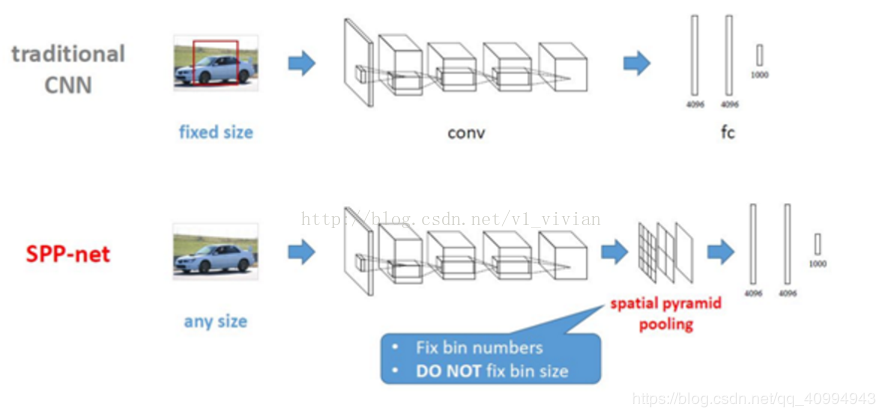

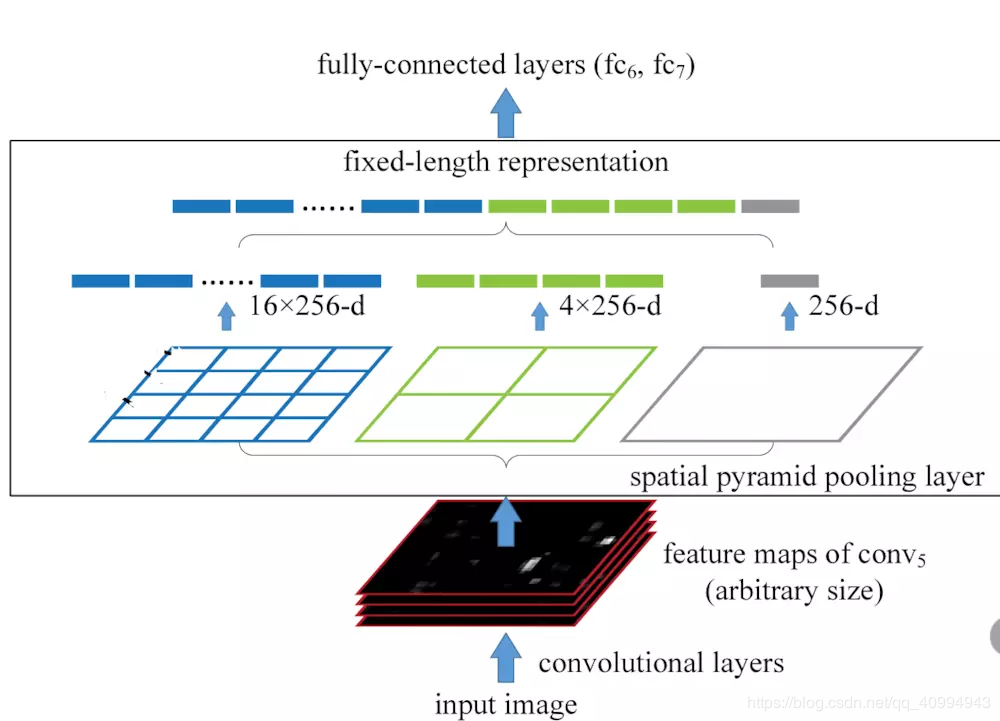

In [7]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np

class SPPBlock(layers.Layer):
    def __init__(self, levels = [4, 2, 1], pool_type = 'max_pool', **kwargs):
        self.levels = levels
        self.pool_type = pool_type
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        
    def call(self, inputs, training=True, **kwargs):
        res, pool = None, None
        for l in self.levels:
            ksize = [np.ceil(inputs.shape[1] / l + 1).astype(np.int32), np.ceil(inputs.shape[2] / l + 1).astype(np.int32)]
            strides = [np.floor(inputs.shape[1] / l + 1).astype(np.int32), np.floor(inputs.shape[2] / l + 1).astype(np.int32)]
            if self.pool_type == 'max_pool':
                pool = layers.MaxPooling2D(pool_size=ksize, strides=strides, padding='SAME')(inputs)
            else:
                pool = layers.AveragePooling2D(pool_size=ksize, strides=strides, padding='SAME')(inputs)
            pool = tf.reshape(pool, (-1, l * l * inputs.shape[3]))
            if res == None:
                res = pool
            else:
                res = tf.concat((res, pool),axis = 1)
        return res

model = tf.keras.Sequential(
[
    Input(shape=(256, 256, 3)),
    layers.Conv2D(256, 3, 1),
    SPPBlock([4, 2, 1], 'max_pool'),
    layers.Dense(10),
    layers.Activation('softmax')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 256)     7168      
_________________________________________________________________
spp_block_7 (SPPBlock)       (None, 5376)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                53770     
_________________________________________________________________
activation_7 (Activation)    (None, 10)                0         
Total params: 60,938
Trainable params: 60,938
Non-trainable params: 0
_________________________________________________________________


# RFB
RFB 模块主要是针对在保持轻量级网络的速度快、计算量小的情况下, 提升检测的精度, 模块如其名, 从感受野角度入手, 增强轻量级网络的特征表示, 主要用来替换one-stage 检测网络的浅层检测头

RFB 模块
如下图所示, RFB 模块由具有不同大小卷积核核扩张率的卷积层构成, 来模拟人类视觉. 对于浅层特征图, 卷积核可以获得更大的感受野. 因而获得更具有表达力的特征.

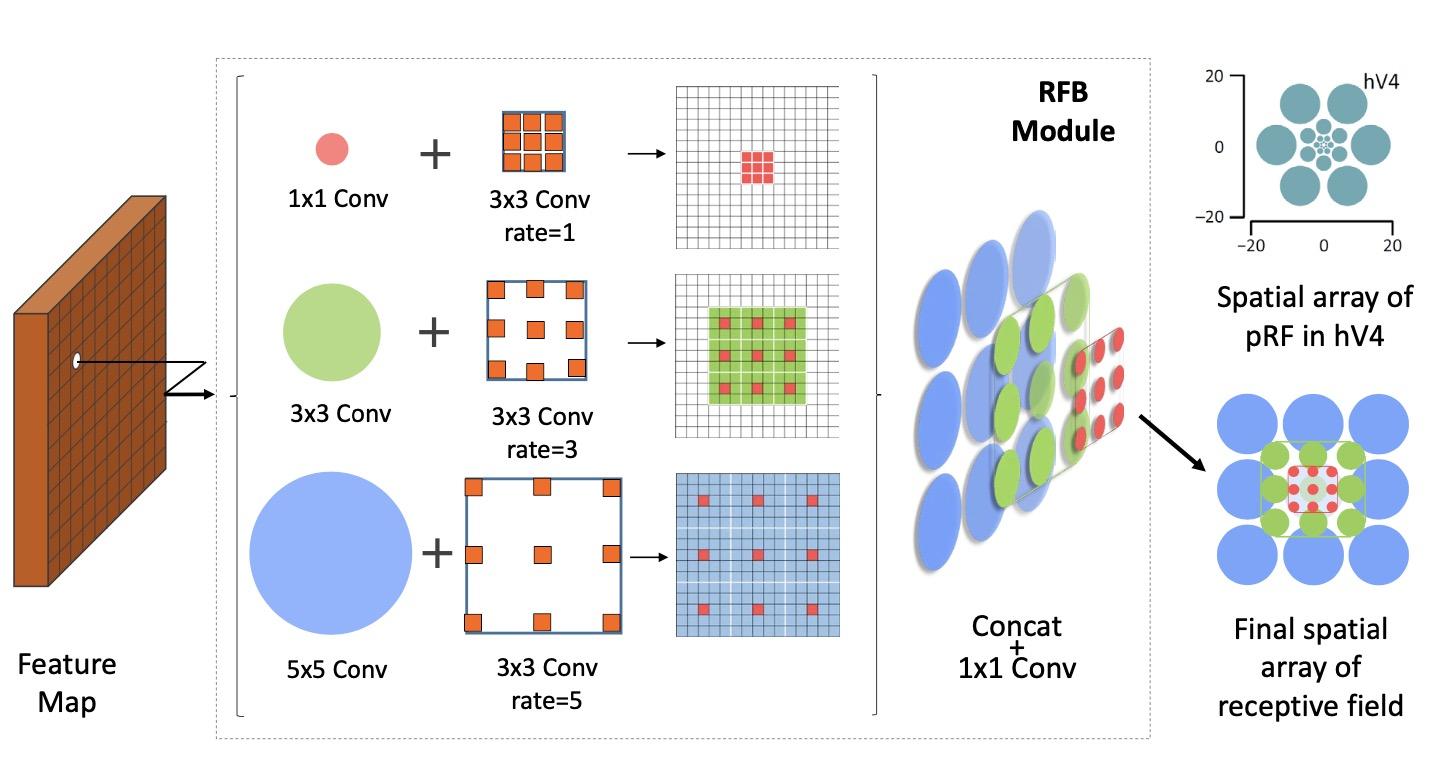

RFB-Net检测器利用多尺度一步检测框架SSD，在其中嵌入RFB模块，模拟人类感受野进行RFB的设计，使得轻量级主干SSD网络也能更快更准。相对较大分辨率的feature map的前卷积层被RFB模块取代。

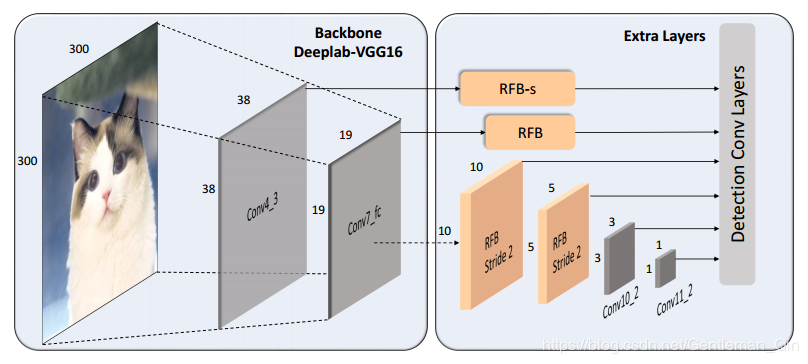

In [53]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np

# Conv + BN + Relu
class BasicConv(layers.Layer):
    def __init__(self, filters, kernel_size, stride=1, padding='same', dilation=1, bn=True, relu=True):
        super().__init__()
        self.layer_conv = layers.Conv2D(filters, kernel_size, stride, padding=padding, dilation_rate=dilation, use_bias=False)
        self.layer_bn = layers.BatchNormalization() if bn else None
        self.layer_relu = layers.Activation('relu') if relu else None

    def call(self, x, training=True, **kwargs):
        x = self.layer_conv(x, training=training)
        if self.layer_bn is not None:
            x = self.layer_bn(x)
        if self.layer_relu is not None:
            x = self.layer_relu(x)
        return x

class BasicRFB(layers.Layer):
    def __init__(self, out_channels, scale=0.1):
        super().__init__()
        self.scale = scale
        self.out_channels = out_channels

    def build(self, input_shape):
        super().build(input_shape)
        
        inter_planes = input_shape[2] // 8
        self.layer_branch0 = [
            BasicConv(2 * inter_planes, kernel_size=1),
            BasicConv(2 * inter_planes, kernel_size=3, dilation=1, relu=False)
        ]
        self.layer_branch1 = [
            BasicConv(inter_planes, kernel_size=1, stride=1),
            BasicConv(2 * inter_planes, kernel_size=3),
            BasicConv(2 * inter_planes, kernel_size=3, dilation=3, relu=False)
        ]
        
        self.layer_branch2 = [
            BasicConv(inter_planes, kernel_size=1),
            BasicConv(2 * inter_planes, kernel_size=3), # use two 3*3 conv to replace one 5*5 conv
            BasicConv(2 * inter_planes, kernel_size=3),
            BasicConv(2 * inter_planes, kernel_size=3, dilation=5, relu=False)
        ]
        
        self.layer_conv_linear = BasicConv(self.out_channels, kernel_size=1, relu=False)
        self.layer_shortcut = BasicConv(self.out_channels, kernel_size=1, relu=False)
        self.layer_relu = layers.Activation('relu')
        
        
    def call(self, x, training=True, **kwargs):
        x0, x1, x2 = x, x, x
        for layer in self.layer_branch0:
            x0 = layer(x0, training=training)
        for layer in self.layer_branch1:
            x1 = layer(x1, training=training)
        for layer in self.layer_branch2:
            x2 = layer(x2, training=training)
            
        out = layers.Concatenate(axis=-1)([x0, x1, x2])
        out = self.layer_conv_linear(out, training=training)
        short = self.layer_shortcut(x, training=training)
        out = out * self.scale + short
        out = self.layer_relu(out)

        return out
    
model = tf.keras.Sequential(
[
    Input(shape=(256, 256, 3)),
    layers.Conv2D(256, 3, 1),
    BasicRFB(128),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(10),
    layers.Activation('softmax')
])
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 254, 254, 256)     7168      
_________________________________________________________________
basic_rfb_30 (BasicRFB)      (None, 254, 254, 128)     264308    
_________________________________________________________________
global_average_pooling2d_27  (None, 128)               0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 10)                1290      
_________________________________________________________________
activation_45 (Activation)   (None, 10)                0         
Total params: 272,766
Trainable params: 271,262
Non-trainable params: 1,504
___________________________________________

# ASSP

In [56]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np

class BasicASSP(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.filters = filters

    def build(self, input_shape):
        super().build(input_shape)
        
        # Atrous Spatial Pyramid Pooling
        # Atrous 1x1
        self.layer_conv1 = layers.Conv2D(self.filters, kernel_size=(1, 1), padding='same')
        # Atrous 3x3, rate = 6
        self.layer_conv2 = layers.Conv2D(self.filters, kernel_size=(3, 3), padding='same', dilation_rate=(12, 12))
        # Atrous 3x3, rate = 12
        self.layer_conv3 = layers.Conv2D(self.filters, kernel_size=(3, 3), padding='same', dilation_rate=(24, 24))
        # Atrous 3x3, rate = 18
        self.layer_conv4 = layers.Conv2D(self.filters, kernel_size=(3, 3), padding='same', dilation_rate=(36, 36))
        # Image Level Pooling
        self.layer_conv_pool = layers.Conv2D(self.filters, kernel_size=(1, 1), padding='same')
        # final
        self.layer_conv_final = layers.Conv2D(self.filters, kernel_size=(1, 1), padding='same')
        
        
    def call(self, x, training=True, **kwargs):
        x0 = self.layer_conv1(x, training=training)
        x1 = self.layer_conv2(x, training=training)
        x2 = self.layer_conv3(x, training=training)
        x3 = self.layer_conv4(x, training=training)
        
        x4 = tf.math.reduce_mean(x, [1, 2], keepdims=True)
        x4 = self.layer_conv_pool(x4, training=training)
        x4 = tf.image.resize(x4, size=[x3.shape[1], x3.shape[2]])
            
        xf = tf.concat(values=[x0, x1, x2, x3, x4], axis=-1)
        xf = self.layer_conv_final(xf, training=training)
        return xf
    
model = tf.keras.Sequential(
[
    Input(shape=(256, 256, 3)),
    layers.Conv2D(16, 3, 1),
    BasicASSP(16),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(10),
    layers.Activation('softmax')
])
model.summary()

(None, 1, 1, 16)
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
basic_assp_13 (BasicASSP)    (None, 254, 254, 16)      8800      
_________________________________________________________________
global_average_pooling2d_30  (None, 16)                0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)                170       
_________________________________________________________________
activation_48 (Activation)   (None, 10)                0         
Total params: 9,418
Trainable params: 9,418
Non-trainable params: 0
__________________________________